# AI for the war against the virus
## Automated pipeline for feature selection


In [1]:
import pandas as pd
import numpy as np

import math
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_similarity_score

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.max_columns=100

C:\Users\Ayelet\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Ayelet\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


### Reading the data

In [2]:
raw_data = pd.read_csv("input/home_ex_raw_data.csv",index_col='serial_number')
raw_data.drop(raw_data.columns[[0]],axis=1,inplace=True)

In [3]:
raw_df = raw_data.copy()
raw_df.head(3)

,test_#_0,test_#_1,test_#_2,test_#_3,test_#_4,test_#_5,test_#_6,test_#_7,test_#_8,test_#_9,test_#_10,test_#_11,test_#_12,test_#_13,test_#_14,test_#_15,test_#_16,test_#_17,test_#_18,test_#_19,test_#_20,test_#_21,test_#_22,test_#_23,test_#_24,test_#_25,test_#_26,test_#_27,test_#_28,test_#_29,test_#_30,test_#_31,test_#_32,test_#_33,test_#_34,test_#_35,test_#_36,test_#_37,test_#_38,test_#_39,test_#_40,test_#_41,test_#_42,test_#_43,test_#_44,test_#_45,test_#_46,test_#_47,test_#_48,test_#_49,...,test_#_1514,test_#_1515,test_#_1516,test_#_1517,test_#_1518,test_#_1519,test_#_1520,test_#_1521,test_#_1522,test_#_1523,test_#_1524,test_#_1525,test_#_1526,test_#_1527,test_#_1528,test_#_1529,test_#_1530,test_#_1531,test_#_1532,test_#_1533,test_#_1534,test_#_1535,test_#_1536,test_#_1537,test_#_1538,test_#_1539,test_#_1540,test_#_1541,test_#_1542,test_#_1543,test_#_1544,test_#_1545,test_#_1546,test_#_1547,test_#_1548,test_#_1549,test_#_1550,test_#_1551,test_#_1552,test_#_1553,test_#_1554,test_#_1555,test_#_1556,test_#_1557,test_#_1558,test_#_1559,test_#_1560,test_#_1561,test_#_1562,Diagnosis
serial_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SZ1218-020512D1C-BA,24631336,246.0,1,159.0,1,1,1,1,1,1,2339.0,2.018011e+13,542190876.0,1,518426.0,1,246.0,1,159.0,1,1,1,1,1,1,2339.0,2.018011e+13,1,333091.0,1,246.0,1,159.0,1,1,1,1,1,1,2339.0,2.018011e+13,333096.0,1,246.0,1,159.0,1,1,1,1,...,1,1,2339.0,2.018011e+13,109.0,19.95112,1,333138.0,1,246.0,1,159.0,1,1,1,1,1,2339.0,2.018011e+13,110.0,333098.0,1,246.0,1,159.0,1,1,1,1,1,2339.0,2.018011e+13,111.0,1,333092.0,1,246,1,159,1,1,1,1,1,1,2339.0,2.018011e+13,333097.0,1,False
SZ1218-020512C9D-3A,24631416,246.0,1,159.0,2,2,1,2,1,1,2339.0,2.018011e+13,542190749.0,1,518426.0,1,246.0,1,159.0,2,2,1,2,1,1,2339.0,2.018011e+13,2,333091.0,1,246.0,1,159.0,2,2,1,2,1,1,2339.0,2.018011e+13,333096.0,1,246.0,1,159.0,2,2,1,2,...,1,1,2339.0,2.018011e+13,109.0,19.89527,1,333138.0,1,246.0,1,159.0,2,2,2,1,1,2339.0,2.018011e+13,110.0,333098.0,1,246.0,1,159.0,2,2,2,1,1,2339.0,2.018011e+13,111.0,1,333092.0,1,246,1,159,2,2,1,2,1,1,2339.0,2.018011e+13,333097.0,1,False
SZ1218-020512802-9B,24631650,295.0,1,159.0,3,3,1,3,1,1,2339.0,2.018011e+13,542189570.0,1,518426.0,1,295.0,1,159.0,3,3,1,3,1,1,2339.0,2.018011e+13,1,333091.0,1,295.0,1,159.0,3,3,1,3,1,1,2339.0,2.018011e+13,333096.0,1,295.0,1,159.0,3,3,1,3,...,1,1,2339.0,2.018011e+13,109.0,20.06003,1,333138.0,1,295.0,1,159.0,3,3,3,1,1,2339.0,2.018011e+13,110.0,333098.0,1,295.0,1,159.0,3,3,3,1,1,2339.0,2.018011e+13,111.0,1,333092.0,1,295,1,159,3,3,1,3,1,1,2339.0,2.018011e+13,333097.0,1,?


### Basic Data Exploration

#### Dropping 8162 samples (patients) without diagnosis taging (? / not found)

In [4]:
raw_df['Diagnosis'].value_counts()

False        68501
?             7718
True           503
not found      444
Name: Diagnosis, dtype: int64

In [5]:
raw_df= raw_df[raw_df['Diagnosis'].isin (['True','False'])]
raw_df['Diagnosis'] = np.where(raw_df['Diagnosis']=='True',1,0)

## Data Exploration

In [6]:
def explore(df):
    print("Number of Attributes:")
    print(df.shape[1]-1)

    print("Number of samples:")
    print(df.shape[0])

    df = df.drop_duplicates()
    print("Number of samples after removing duplicates:")
    print(df.shape[0])
    
    print("\nClass distribution:")
    print(df['Diagnosis'].value_counts(normalize=True))
    
    #print("\nNumber of NaNs:")
    #print(df.isnull().sum())
    
    null_df = pd.DataFrame({'num_nulls': df.isnull().sum()})
    null_df = null_df[null_df['num_nulls']>0]
    print("\nNumber of features with NaNs:",'\n',null_df.shape[0])
    print("\nMax NaNs in a feature:",'\n',null_df['num_nulls'].max())
    
    #print("\nData Types")
    #print(df.dtypes)

    #print("\nDescriptive Statistics:")
    #print(df.describe(include='all'))


In [7]:
explore(raw_df)

Number of Attributes:
1563
Number of samples:
69004
Number of samples after removing duplicates:
69004

Class distribution:
0    0.992711
1    0.007289
Name: Diagnosis, dtype: float64

Number of features with NaNs: 
 723

Max NaNs in a feature: 
 1998


# Intro

    
#### There are two main issues we need to address:<br>
1) The `data is highly imbalanced`. Only 0.07!! percent of the patients are diagnosed positive to the virus.<br>
2) There are `a LOT of features` (tests) that we need to reduce in order to:
        - avoid overfitting (Curse of dimensionality)
        - keep our model simple and explainable
        - reduce computation time and storage space
   We will use feature selection techniques and not feature extraction to save the original features for later model interpretability ability.<br>
   
   We will use two feature selection methods in two stages:<br>
   
   **Stage I**:   Filtering of uninformative features. <br>
   **--------**<br>
   A)  **Filter based method:** We specify some metrics and filter features based on their values. <br>
          Our filter matrics are:
          * Features with more then 70% NaN's
          * Low variance features
          * Highly correlated features
   
   **Stage II**: Selecting the x "best" features.<br> 
   **--------** <br>
   B)  **comparative based method:** Building a comparative table to choose the x most significant features (tests). <br>
          Our filter matrics are:
          * Highest correlation/dependence with the target value 'Diagnosis'. 
            Measured with chi-squared for qualitative features and Pearson’s correlation absolute value for 
            quantitative
          * Highest importance. Measured by using Algorithms that have embedded feature selection 
            methods like Regularization.       


## Stage I: Preprossesing

In [8]:
df_w = raw_df.copy()

### Dropping features with too much missing values

In [9]:
def drop_feat_with_to_many_nan(df, AT_LEAST_NON_MISSING_PERCENT = 0.7):
    print ( "\nStart drop NaNs features function")
    #AT_LEAST_NON_MISSING_PERCENT = 0.7  # require at most 30% missing values per feature
    AT_LEAST_NON_MISSING = math.floor(AT_LEAST_NON_MISSING_PERCENT * len(df))
    n_cols = len(df.columns)
    df.dropna(axis=1, thresh=AT_LEAST_NON_MISSING, inplace=True)    
    
    print("{} features dropped dut to high NaN's proportion".format(n_cols - len(df.columns)))
    print("{} features in data-set after NaN's drop.".format(df.shape[1]))
    return df

### Dropping features with low variance

In [10]:
def drop_feat_with_low_var(df, CENTERED_PERCENT=0.8, LOW_VAR_VAL=0.2):
    print ( "\nStart drop low var features function")
    features_list = df.columns.tolist()
    features_list.remove('Diagnosis')
    
    low_var_features_list = []
    categorical_features_list = []
    numerical_features_list = []

    #dividing the features into categorical and numerical
    for ftr in features_list:
        if df[ftr].nunique()<=20:
            categorical_features_list.append(ftr)
        else:
            numerical_features_list.append(ftr)

    #categorical features with low variance
    for ftr in categorical_features_list:
        if df[ftr].value_counts(normalize = True).max() >= CENTERED_PERCENT:
            low_var_features_list.append(ftr)

    #numerical features with low variance
    for ftr in numerical_features_list:
        if df[ftr].var() <= LOW_VAR_VAL:
            low_var_features_list.append(ftr)          

    df.drop(low_var_features_list,axis=1,inplace=True)
    
    print("{} features dropped due to low variance".format(len(low_var_features_list)))
    print("{} features in data-set after low var drop".format(df.shape[1]))
    return df

### Dropping features that are highly correlared

In [11]:
def drop_high_corr_feat(df, HIGH_CORR_VAL=0.9):
    print ( "\nStart drop correlated features function")
    features_list = df.columns.tolist()
    features_list.remove('Diagnosis')

    new_ftr_list = []
    rmv_list = []
    corr_ftr_dict = {}

    for ftr in features_list:
        if ftr in rmv_list:
            continue
        else:
            new_ftr_list.append(ftr)
        for j in features_list:
            if j in new_ftr_list:
                continue
            if j in rmv_list:
                continue
            if abs(df[[ftr, j]].corr().iloc[0,1]) >= HIGH_CORR_VAL:
                rmv_list.append(j)
                corr_ftr_dict[ftr] = j
            
    df.drop(rmv_list,axis=1,inplace=True)
    
    print("{} features dropped due to high correlation".format(len(rmv_list)))
    print("{} features in data-set after correlation drop".format(df.shape[1]))
    return df

### Imputing features with NaN values
qualitative (categorical) features with the mode, and quanitative with the mean

In [12]:
def feat_impu(df):
    print ( "\nStart features imputation function")
    features_list = df.columns.tolist()
    missing_list = df.isnull().sum()[df.isnull().sum()>0].keys().tolist()

    qualitative_ftr_miss_list = []
    quanitative_ftr_miss_list = []

    imputer_qual = SimpleImputer(strategy='most_frequent')
    imputer_quan = SimpleImputer()
    
    if len(missing_list) > 0:
        for ftr in missing_list:
            if df[ftr].nunique() <= 20:
                qualitative_ftr_miss_list.append(ftr)
            else:
                quanitative_ftr_miss_list.append(ftr)

    if len(qualitative_ftr_miss_list) > 0:
        df[qualitative_ftr_miss_list] = imputer_qual.fit_transform(df.loc[:, qualitative_ftr_miss_list])
    if len(quanitative_ftr_miss_list) > 0:
        df[quanitative_ftr_miss_list] = imputer_quan.fit_transform(df.loc[:, quanitative_ftr_miss_list])
    
    print( "Number of features with NaNs:", len(df.isnull().sum()[df.isnull().sum() > 0]) )
    return df

### stage I preprocessing pipeline

In [13]:
def preprocess(df):
    df = drop_feat_with_to_many_nan(df)
    df = drop_feat_with_low_var(df)
    df = drop_high_corr_feat(df)
    df = feat_impu(df)
        
    print ( "\nEnd preprocessing")
    print("\nNumber of Attributes:", df.shape[1]-1)
    print("Number of samples:", df.shape[0])
    print("\nClass distribution:")
    print(df['Diagnosis'].value_counts(normalize=True))

    return df

## Stage II: Ensemble feature selection 

### Synthetic creating less imbalance data-set
To address the imbalance issue, we will create a less imbalance data-set with 1:3 target class relation for further use of the algorithms.

In [14]:
def rebalance(df, SCALE = 3):
    positive_df = df[df['Diagnosis'] == 1]
    negative_df = df[df['Diagnosis'] == 0]
    n = int(SCALE * positive_df.shape[0])
    rebalance_df = pd.concat([positive_df, negative_df.sample(n)])

    print("\nrebalanced data class distribution:")
    print(rebalance_df['Diagnosis'].value_counts(normalize=True))
    print("rebalanced Number of samples:", rebalance_df.shape[0])
    return rebalance_df 

### Pearson Correlation

In [15]:
def cor_selector(df, num_feats = 20):
    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print("\n", str(len(cor_feature)), 'selected features by pearson correlation')
    return cor_support, cor_feature

### Chi-Squared

In [16]:
def chi_selector(df, num_feats = 20):
    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']
    feature_list = X.columns.tolist()
    qualitative_ftr_list = []
    
    for ftr in feature_list:
        if df[ftr].nunique() <= 20:
            qualitative_ftr_list.append(ftr)
    
    #X = df.loc[:, qualitative_ftr_list]
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print("\n", str(len(chi_feature)), 'selected features by chi-squared')
    return chi_support, chi_feature

### Lasso regression with L1 norm regularizer

In [17]:
def lasso_selector(df, num_feats = 20):
    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    X_norm = StandardScaler().fit_transform(X)

    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, y)

    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print("\n", str(len(embeded_lr_feature)), 'selected features by lasso')
    return embeded_lr_support, embeded_lr_feature

### RandomForest

In [18]:
def randomforest_selector(df, num_feats = 20):
    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    X_norm = StandardScaler().fit_transform(X)

    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=50), max_features=num_feats)
    embeded_rf_selector.fit(X, y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print("\n", str(len(embeded_rf_feature)), 'selected features by random forest')
    return embeded_rf_support, embeded_rf_feature

### Feature selection summarize table

In [19]:
def ftr_comp_table(df, num_select_feats = 20, rblnc_scale = 1):
    df = preprocess(df)
    X = df.drop('Diagnosis', axis=1)
    feature_name = X.columns.tolist()
    
    reblnc_df = rebalance(df, SCALE = rblnc_scale)

    cor_support, cor_feature = cor_selector(df, num_feats = num_select_feats)
    chi_support, chi_feature = chi_selector(df, num_feats = num_select_feats)
    embeded_lr_support, embeded_lr_feature = lasso_selector(reblnc_df, num_feats = num_select_feats)
    embeded_rf_support, embeded_rf_feature = randomforest_selector(reblnc_df, num_feats = num_select_feats)
        
    # put all selection together
    feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support,\
                                         'Lasso':embeded_lr_support, 'Random Forest':embeded_rf_support})
    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    # display by the top features
    feature_selection_tbl = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df)+1)
    return feature_selection_tbl

In [20]:
tbl = ftr_comp_table(df_w, num_select_feats = 8, rblnc_scale = 8)
tbl.head()


Start drop NaNs features function
0 features dropped dut to high NaN's proportion
1564 features in data-set after NaN's drop.

Start drop low var features function
268 features dropped due to low variance
1296 features in data-set after low var drop

Start drop correlated features function
1255 features dropped due to high correlation
41 features in data-set after correlation drop

Start features imputation function
Number of features with NaNs: 0

End preprocessing

Number of Attributes: 40
Number of samples: 69004

Class distribution:
0    0.992711
1    0.007289
Name: Diagnosis, dtype: float64

rebalanced data class distribution:
0    0.888889
1    0.111111
Name: Diagnosis, dtype: float64
rebalanced Number of samples: 4527

 8 selected features by pearson correlation

 8 selected features by chi-squared

 8 selected features by lasso

 8 selected features by random forest


,Feature,Pearson,Chi-2,Lasso,Random Forest,Total
33,test_#_950,True,True,True,False,3
2,test_#_2,True,True,True,False,3
29,test_#_879,True,True,False,False,2
23,test_#_728,False,True,False,True,2
17,test_#_538,False,False,True,True,2


-----

# Goal Function
### The pipeline of the entire process
The function gets as `INPUT` --> Full raw data (after minor specific corrections, if needed). <br>
Function `OUTPUT` --> Processed data with only X features, X can be dynamically defined by the user. <br>

In [21]:
def data_for_model(df, num_select_feat = 20, rbalc_scale = 1):
    
    preprocess(df)
    ftr_select_tbl = ftr_comp_table(df, num_select_feats = num_select_feat, rblnc_scale = rbalc_scale)   
    
    selected_ftr_list = ftr_select_tbl.iloc[0:num_select_feat, 0].tolist()
    selected_ftr_list.append('Diagnosis')
    model_df_output = df.loc[:, selected_ftr_list]
    return model_df_output

In [22]:
model_df = data_for_model(df_w, num_select_feat = 15, rbalc_scale = 3)


Start drop NaNs features function
0 features dropped dut to high NaN's proportion
41 features in data-set after NaN's drop.

Start drop low var features function
0 features dropped due to low variance
41 features in data-set after low var drop

Start drop correlated features function
0 features dropped due to high correlation
41 features in data-set after correlation drop

Start features imputation function
Number of features with NaNs: 0

End preprocessing

Number of Attributes: 40
Number of samples: 69004

Class distribution:
0    0.992711
1    0.007289
Name: Diagnosis, dtype: float64

Start drop NaNs features function
0 features dropped dut to high NaN's proportion
41 features in data-set after NaN's drop.

Start drop low var features function
0 features dropped due to low variance
41 features in data-set after low var drop

Start drop correlated features function
0 features dropped due to high correlation
41 features in data-set after correlation drop

Start features imputation fu

In [23]:
model_df.shape

(69004, 16)

======================================================================================================================

## ;-) Bonus  - Modelling

After fitting a Random Forest predictor over our processed data, we got pretty good scores over the training set (about 97% accuracy and f1-score), but much less performance over the test set (only about 68% accuracy and f1-score).
For this kind of problem (predicting virus illness), we don't want to miss any ill patients, so it is highly essential to have minimum type-1 error (false negative), i.e., **`high recall`**. It is also important to have low type-2 error (false positive), i.e., **`high precision`**, to avoid misdiagnosis.The **`f1-score`**, the harmonic mean of precision and recall, is a suitable measure.

In [24]:
model_df.head(3)

,test_#_760,test_#_0,test_#_932,test_#_744,test_#_728,test_#_2,test_#_950,test_#_914,test_#_896,test_#_879,test_#_862,test_#_777,test_#_774,test_#_649,test_#_538,Diagnosis
serial_number,,,,,,,,,,,,,,,,
SZ1218-020512D1C-BA,1,24631336,1,1,1,1,48.0,1,1,1,1,48.0,63.0,12.0,53.0,0
SZ1218-020512C9D-3A,1,24631416,1,2,2,1,44.0,1,1,1,2,44.0,63.0,12.0,13.0,0
SZ1218-02051280A-A3,1,24631652,1,1,4,1,48.0,1,1,1,1,48.0,63.0,8.0,46.0,0


### Synthetic Balanced Data

In [25]:
model_df_1 = rebalance(model_df, SCALE = 3)


rebalanced data class distribution:
0    0.75
1    0.25
Name: Diagnosis, dtype: float64
rebalanced Number of samples: 2012


In [26]:
X = model_df_1.drop('Diagnosis', axis=1)
y = model_df_1['Diagnosis']

### Data Split (stratified)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

## Fit Random Forest Model

In [28]:
clf1 = RandomForestClassifier(random_state=1)

classifiers = [('RF', clf1)]
fi_classifiers_list = ['RF']

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)

In [30]:
print ("\n===========================================================================================================")
results_train = y_train.to_frame()
results_test = y_test.to_frame()

#fi_df = {}
fi_df = pd.DataFrame(X_train.columns, columns = ['feature'])
confusion_matrixs_train = {}
confusion_matrixs_test = {}

for clf_name, clf in classifiers:
    model = clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    results_train[clf_name] = clf.predict(X_train)
    results_test[clf_name] = clf.predict(X_test)
    
    print ('{:2} classifier:\n \
        \tTrain Accuracy: {:.2f}\n \
        \tTest Accuracy: {:.2f}'\
               .format(clf_name,
               clf.score(X_train, y_train),
               clf.score(X_test, y_test)))

    # Compute train classification report
    print ("\nTrain Classification Report:")
    print(classification_report(y_true=y_train,
                            y_pred=y_pred_train))
    
    # Compute train confusion matrix
    cnf_matrix_train = confusion_matrix(y_true=y_train, y_pred=results_train[clf_name])
    confusion_matrixs_train[clf_name] = cnf_matrix_train
    
    print ("\nTrain Confusion Matrix:")
    print (pd.DataFrame(cnf_matrix_train,
             index = clf.classes_,
             columns = clf.classes_))
    
    # Compute test classification report    
    print ("\nTest Classification Report:")
    print(classification_report(y_true=y_test,
                            y_pred=y_pred_test))

    # Compute test confusion matrix
    cnf_matrix_test = confusion_matrix(y_true=y_test, y_pred=results_test[clf_name])
    confusion_matrixs_test[clf_name] = cnf_matrix_test

    print ("\nTest Confusion Matrix:")
    print (pd.DataFrame(cnf_matrix_test,
             index = clf.classes_,
             columns = clf.classes_))
    
    # Compute feature importance matrix
    print ("\nFeature Importance by PermutationImportance method:")
    perm = PermutationImportance(clf).fit(X_train, y_train)
    print ( eli5.format_as_text(eli5.explain_weights(perm, top=8, feature_names = X_train.columns.tolist())) )

    if clf_name in fi_classifiers_list:
        fi_df[clf_name+'_fi_score'] = clf.feature_importances_[:, ]
        fi_df[clf_name+'_rel_fi_score'] = fi_df[clf_name+'_fi_score'] / fi_df[clf_name+'_fi_score'].max()
    
    
    print ("\n=================================================================================================")


RF classifier:
         	Train Accuracy: 0.98
         	Test Accuracy: 0.71

Train Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1207
           1       1.00      0.91      0.95       402

   micro avg       0.98      0.98      0.98      1609
   macro avg       0.99      0.96      0.97      1609
weighted avg       0.98      0.98      0.98      1609


Train Confusion Matrix:
      0    1
0  1207    0
1    35  367

Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       302
           1       0.35      0.18      0.24       101

   micro avg       0.71      0.71      0.71       403
   macro avg       0.56      0.53      0.53       403
weighted avg       0.66      0.71      0.68       403


Test Confusion Matrix:
     0   1
0  269  33
1   83  18

Feature Importance by PermutationImportance method:
Explained as: feature importances

F

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

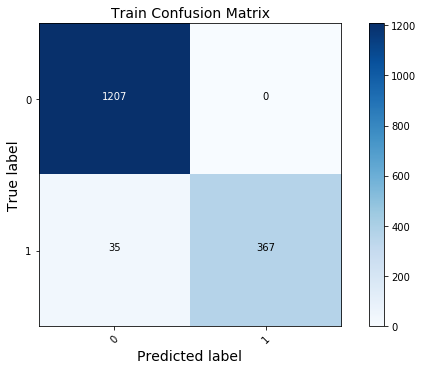

In [31]:
plt.figure()
plt.figure(figsize=(8,5))
plot_confusion_matrix(confusion_matrixs_train['RF'],
                      classes=clf.classes_,normalize= False,  title='Train Confusion Matrix')

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

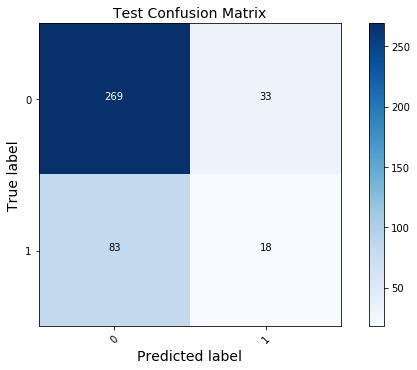

In [32]:
plt.figure()
plt.figure(figsize=(8,5))
plot_confusion_matrix(confusion_matrixs_test['RF'],
                      classes=clf.classes_,normalize= False,  title='Test Confusion Matrix')

-

# <center> THE END <center>